<a href="https://colab.research.google.com/github/aianshay/sales-time-series/blob/main/neural_net_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 63 kB 24.4 MB/s 
     |████████████████████████████████| 6.4 MB 40.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 25.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Imports

In [96]:
import yfinance as yf

from google.colab import drive

from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
mpl.rcParams['figure.figsize'] = [10, 5]
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data

In [5]:
sales = pd.read_csv('/content/drive/MyDrive/data/store-sales/train.csv')
sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
sales.shape

(3000888, 6)

# Preprocessing

In [7]:
ts = sales.query('store_nbr == 1 and family == "PERSONAL CARE"')

In [8]:
ts = ts.drop(columns=['id', 'store_nbr', 'family', 'onpromotion'])

In [9]:
ts.head()

,date,sales
25,2013-01-01,0.0
1807,2013-01-02,194.0
3589,2013-01-03,153.0
5371,2013-01-04,88.0
7153,2013-01-05,141.0


In [10]:
ts.index = ts.date
ts = ts.drop(columns='date')

ts.head()

,sales
date,
2013-01-01,0.0
2013-01-02,194.0
2013-01-03,153.0
2013-01-04,88.0
2013-01-05,141.0


In [11]:
ts.shape

(1684, 1)

In [12]:
ts.isna().sum()

sales    0
dtype: int64

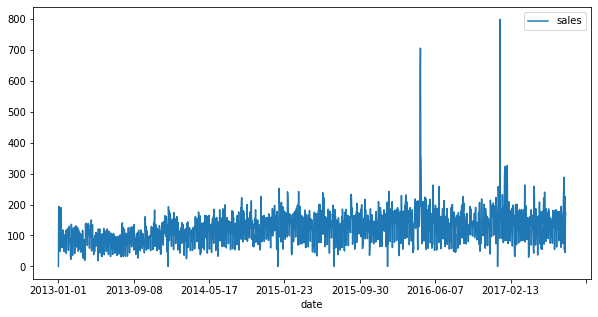

In [13]:
ts.plot()

In [21]:
sales_train, sales_test = train_test_split(ts, test_size=0.5, shuffle=False)
sales_test, sales_val = train_test_split(sales_test, test_size=0.5, shuffle=False)

In [22]:
sales_train

,sales
date,
2013-01-01,0.0
2013-01-02,194.0
2013-01-03,153.0
2013-01-04,88.0
2013-01-05,141.0
...,...
2015-04-20,151.0
2015-04-21,153.0
2015-04-22,150.0


In [23]:
sales_test

,sales
date,
2015-04-25,150.0
2015-04-26,47.0
2015-04-27,124.0
2015-04-28,122.0
2015-04-29,114.0
...,...
2016-06-15,163.0
2016-06-16,144.0
2016-06-17,121.0


In [24]:
sales_val

,sales
date,
2016-06-20,258.0
2016-06-21,116.0
2016-06-22,153.0
2016-06-23,154.0
2016-06-24,111.0
...,...
2017-08-11,53.0
2017-08-12,227.0
2017-08-13,45.0


**Será que modelos de machine learning poderiam descobrir relações e padrões não lineares, que os modelos clássicos lineares não conseguem?** 🤔:

# Analysis

## Seasonal Decomposing

In [29]:
ts_decomp = tsa.seasonal_decompose(ts, period=365)

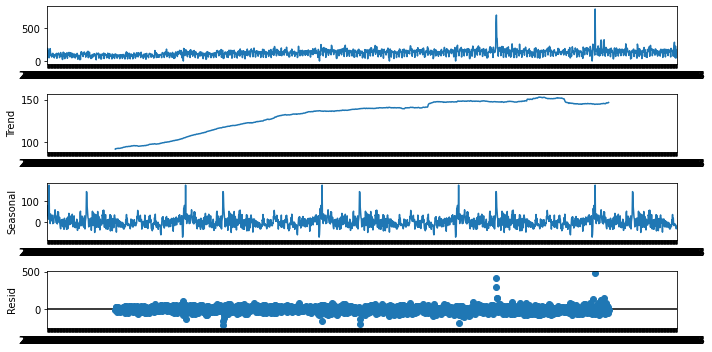

In [30]:
ts_decomp.plot();

## Stationarity

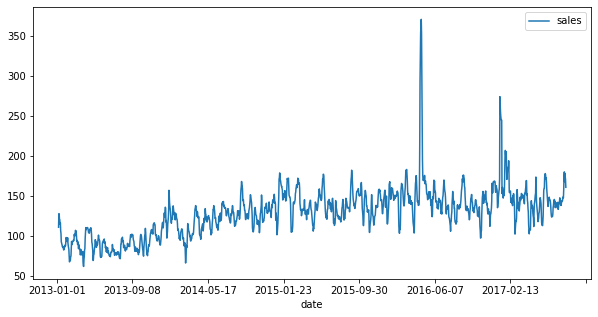

In [31]:
ts.rolling(7).mean().plot();

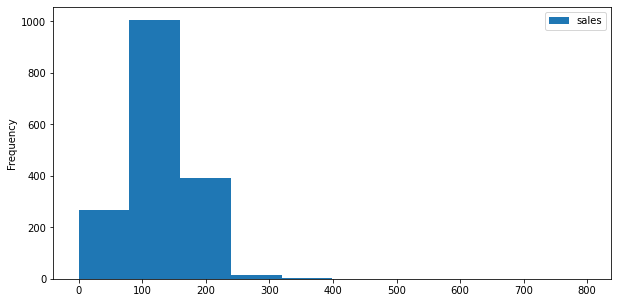

In [33]:
ts.plot.hist();

## 1st order difference

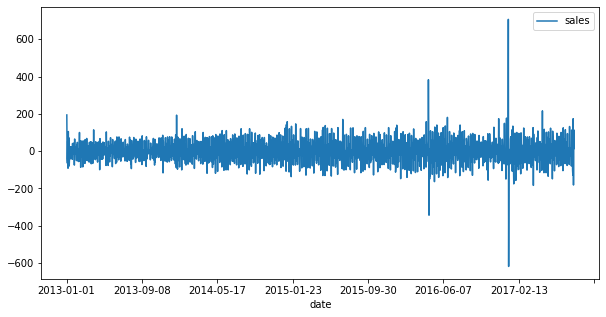

In [34]:
ts.diff().plot()

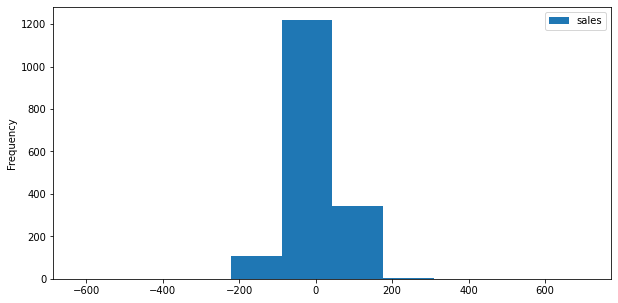

In [36]:
ts.diff().plot.hist();

In [44]:
ts_diff = ts.diff().dropna()

## Autocorrelation

A correlation of a variable with itself at different times
is known as autocorrelation or serial correlation.

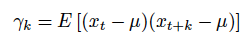

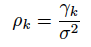

In [37]:
ts.shift(-1)

,sales
date,
2013-01-01,194.0
2013-01-02,153.0
2013-01-03,88.0
2013-01-04,141.0
2013-01-05,49.0
...,...
2017-08-11,227.0
2017-08-12,45.0
2017-08-13,159.0


In [38]:
ts.corrwith(ts.shift(-1))

sales    0.278298
dtype: float64

In [46]:
ts_diff.corrwith(ts_diff.shift(-1))

sales   -0.507911
dtype: float64

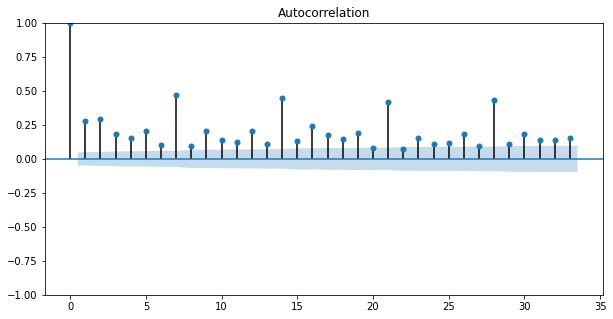

In [42]:
plot_acf(ts);

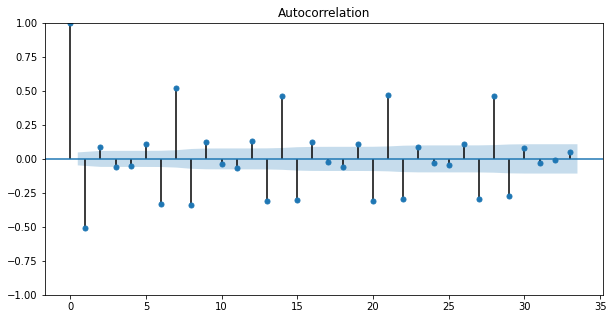

In [45]:
plot_acf(ts_diff);

## Partial Autocorrelation

The partial autocorrelation at lag k is the correlation that
results after removing the effect of any correlations due to the terms at shorter
lags.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


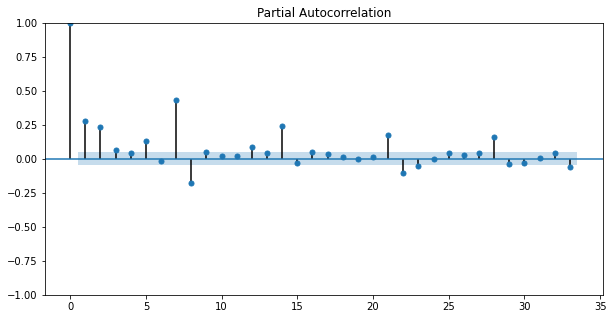

In [43]:
plot_pacf(ts);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


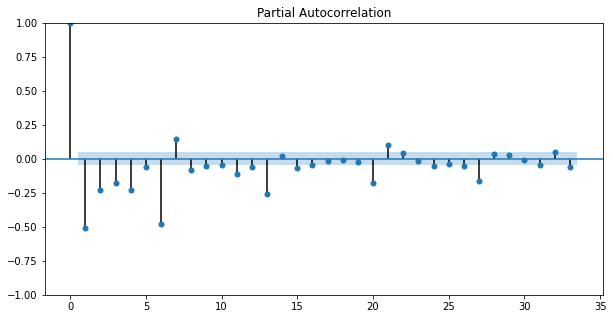

In [48]:
plot_pacf(ts_diff);

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

# Feature Engineering

In [49]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [50]:
get_lags(ts, 3)

,sales-1,sales-2,sales-3
date,,,
2013-01-04,153.0,194.0,0.0
2013-01-05,88.0,153.0,194.0
2013-01-06,141.0,88.0,153.0
2013-01-07,49.0,141.0,88.0
2013-01-08,154.0,49.0,141.0
...,...,...,...
2017-08-11,183.0,288.0,239.0
2017-08-12,53.0,183.0,288.0
2017-08-13,227.0,53.0,183.0


In [51]:
X = get_lags(ts, 5)

In [52]:
X.head()

,sales-1,sales-2,sales-3,sales-4,sales-5
date,,,,,
2013-01-06,141.0,88.0,153.0,194.0,0.0
2013-01-07,49.0,141.0,88.0,153.0,194.0
2013-01-08,154.0,49.0,141.0,88.0,153.0
2013-01-09,119.0,154.0,49.0,141.0,88.0
2013-01-10,190.0,119.0,154.0,49.0,141.0


In [53]:
y = ts.reindex(X.index)

In [54]:
y.head()

,sales
date,
2013-01-06,49.0
2013-01-07,154.0
2013-01-08,119.0
2013-01-09,190.0
2013-01-10,110.0


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1343, 5)
(1343, 1)
(336, 5)
(336, 1)


# KNN

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_nca_illustration_001.png)

![KNN](https://scikit-learn.org/stable/_images/sphx_glr_plot_regression_001.png)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

Hyperparameters:

* K 
* weights
* distance

In [56]:
from sklearn.neighbors import KNeighborsRegressor

In [57]:
neigh = KNeighborsRegressor(n_neighbors=2, weights='distance')
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2, weights='distance')

In [64]:
preds = neigh.predict(X_test)

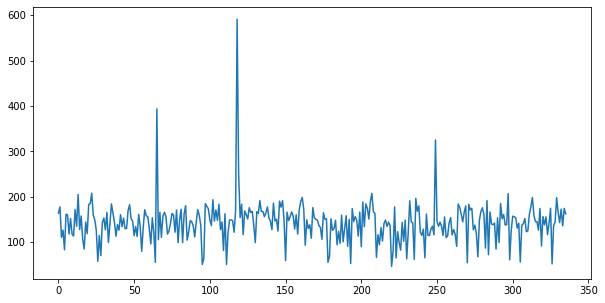

In [66]:
pd.Series(preds.flatten()).plot();

In [72]:
results = {}
results['KNN'] = {'r2': r2_score(preds, y_test), 
                  'mse': mean_squared_error(preds, y_test), 
                  'mae': mean_absolute_error(preds, y_test)}
print('Sales Forecast - KNN Results')
print(results)

Sales Forecast - KNN Results
{'KNN': {'r2': -1.2394385379486592, 'mse': 4634.026099637032, 'mae': 41.61584293503442}}


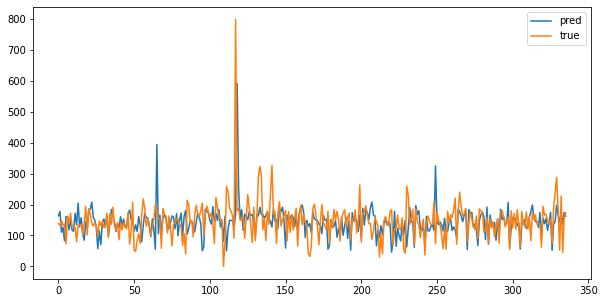

In [75]:
fig, ax = plt.subplots()
ax.plot(preds.flatten(), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')

plt.legend()

E agora?

#SVR

In [77]:
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.2, kernel='linear')

In [78]:
regr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(epsilon=0.2, kernel='linear')

In [79]:
y_pred = regr.predict(X_test)

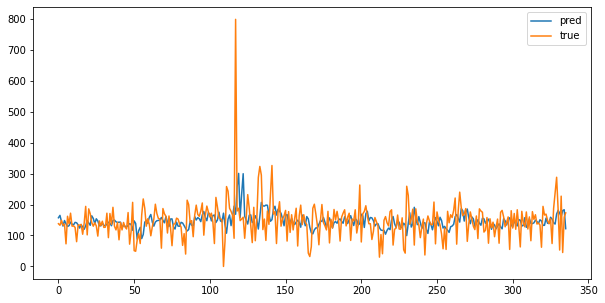

In [81]:
fig, ax = plt.subplots()

ax.plot(y_pred, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')

plt.legend()

In [82]:
results['SVR'] = {'r2':r2_score(y_pred, y_test), 
                  'mse': mean_squared_error(y_pred, y_test), 
                  'mae': mean_absolute_error(y_pred, y_test)}

print('Sales Forecast - SVR Results')
print(results)

Sales Forecast - SVR Results
{'KNN': {'r2': -1.2394385379486592, 'mse': 4634.026099637032, 'mae': 41.61584293503442}, 'SVR': {'r2': -6.388991153366971, 'mse': 4022.839105099348, 'mae': 41.331126829861226}}


Fiquei rico? 

Negociar ações é mais complicado do que fazer previsão de um passo a frente. 

O retorno geralmente ocorre a longo prazo, por isso um dos desafios é prever vários passos a frente.

In [83]:
X_train

,sales-1,sales-2,sales-3,sales-4,sales-5
date,,,,,
2013-01-06,141.0,88.0,153.0,194.0,0.0
2013-01-07,49.0,141.0,88.0,153.0,194.0
2013-01-08,154.0,49.0,141.0,88.0,153.0
2013-01-09,119.0,154.0,49.0,141.0,88.0
2013-01-10,190.0,119.0,154.0,49.0,141.0
...,...,...,...,...,...
2016-09-08,145.0,203.0,184.0,92.0,197.0
2016-09-09,226.0,145.0,203.0,184.0,92.0
2016-09-10,180.0,226.0,145.0,203.0,184.0


In [84]:
get_lags(pd.DataFrame(ts), -7)

,sales+1,sales+2,sales+3,sales+4,sales+5,sales+6,sales+7
date,,,,,,,
2013-01-01,194.0,153.0,88.0,141.0,49.0,154.0,119.0
2013-01-02,153.0,88.0,141.0,49.0,154.0,119.0,190.0
2013-01-03,88.0,141.0,49.0,154.0,119.0,190.0,110.0
2013-01-04,141.0,49.0,154.0,119.0,190.0,110.0,81.0
2013-01-05,49.0,154.0,119.0,190.0,110.0,81.0,103.0
...,...,...,...,...,...,...,...
2017-08-04,154.0,74.0,187.0,239.0,288.0,183.0,53.0
2017-08-05,74.0,187.0,239.0,288.0,183.0,53.0,227.0
2017-08-06,187.0,239.0,288.0,183.0,53.0,227.0,45.0


In [85]:
y_train_multi = get_lags(pd.DataFrame(y_train), -7)
y_test_multi = get_lags(pd.DataFrame(y_test), -7)

In [86]:
X_train_multi, y_train_multi = X_train.align(y_train_multi, join='inner', axis=0) 
X_test_multi, y_test_multi = X_test.align(y_test_multi, join='inner', axis=0) 

In [87]:
X_train_multi.index is y_train_multi.index

True

In [88]:
X_test_multi.index is y_test_multi.index

True

In [89]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor

In [90]:
regr_multi = MultiOutputRegressor(LinearSVR(C=1.0, epsilon=0.2))

In [91]:
regr_multi.fit(X_train_multi, y_train_multi)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

MultiOutputRegressor(estimator=LinearSVR(epsilon=0.2))

In [92]:
y_pred_multi = regr_multi.predict(X_test_multi)

In [93]:
regr_multi.predict(X_test_multi).shape

(329, 7)

In [94]:
results['SVR multi'] = {'r2':r2_score(y_pred_multi, y_test_multi), \
                        'mse': mean_squared_error(y_pred_multi, y_test_multi), 
                        'mae': mean_absolute_error(y_pred_multi, y_test_multi)}

print('Prices - SVR Multi Results')
results

Prices - SVR Multi Results


{'KNN': {'mae': 41.61584293503442,
  'mse': 4634.026099637032,
  'r2': -1.2394385379486592},
 'SVR': {'mae': 41.331126829861226,
  'mse': 4022.839105099348,
  'r2': -6.388991153366971},
 'SVR multi': {'mae': 46.47277327991145,
  'mse': 5171.873146209151,
  'r2': -2.512108425690895}}

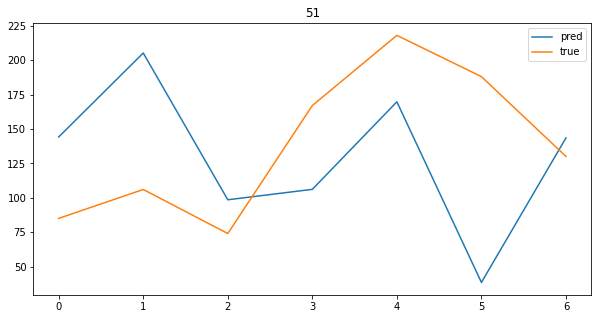

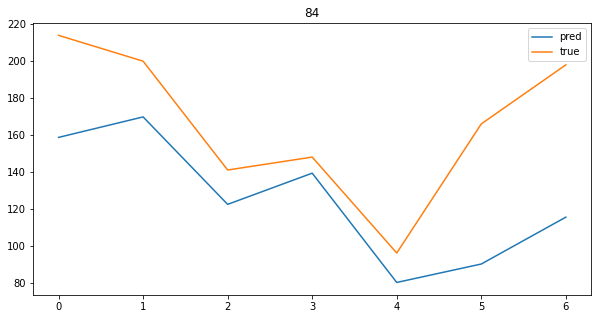

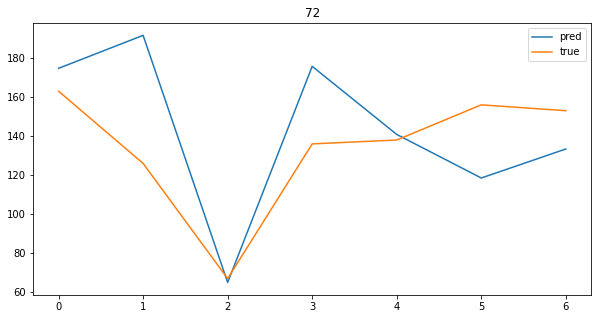

In [97]:
for day in np.random.randint(1,100,3):
  fig, ax = plt.subplots()
  pd.Series(y_pred_multi[day]).plot(label='pred')
  pd.Series(pd.DataFrame(y_test_multi).reset_index(drop=True).loc[day].values).plot(label='true')
  plt.title(day)
  plt.legend()

In [98]:
pd.DataFrame(results)

,KNN,SVR,SVR multi
r2,-1.239439,-6.388991,-2.512108
mse,4634.026100,4022.839105,5171.873146
mae,41.615843,41.331127,46.472773


# MLP

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

https://pytorch.org/tutorials/beginner/basics/intro.html

### Graphs

In [ ]:
!sudo apt-get install graphviz graphviz-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.40.1-2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2

In [ ]:
pip install pygraphviz

     |████████████████████████████████| 118 kB 5.2 MB/s 
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165752 sha256=8e322f4f928f86ed84946dfaa7ff2b60b0d19e836a696d46e41361cef7630d80
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


In [ ]:
import pygraphviz

In [ ]:
import networkx as nx

In [ ]:
g1 = nx.DiGraph()
for i in range(1,6):
  g1.add_edge(i,'n1')
g1.add_edge('n1','out')
A = nx.nx_agraph.to_agraph(g1)
A.draw("g1.png", prog="dot", )

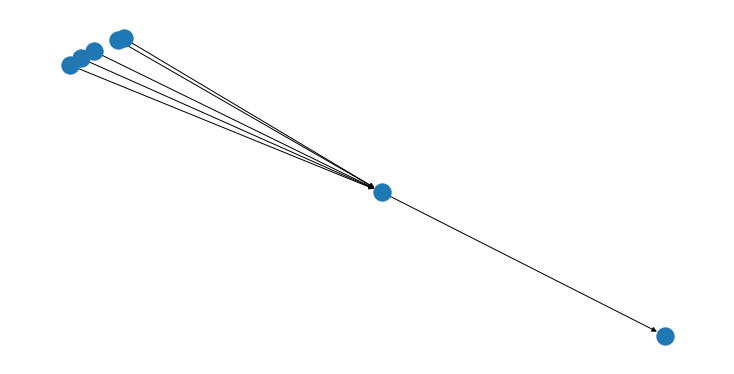

In [ ]:
nx.draw_kamada_kawai(g1)

In [ ]:
camada entrada = [1,2,3,4]
neuronios = [1,2,3,4][1,2,3,4][1,2,3,4]
ativacao = relu(neuronios)
output = ativacao

erro = grad(neuronios)


In [ ]:
g2 = nx.DiGraph()
"""
# X
for i in range(1,5):
  g2.add_node(i)

# y
g2.add_node('out')

# Neurons
for j in ('n1','n2','n3'):
  g2.add_node(j)
"""
# Conexões
for i in range(1,5):
  for j in ('n1','n2','n3'):
    g2.add_edge(i,j)
    g2.add_edge(j,'out')
B = nx.nx_agraph.to_agraph(g2)
B.draw("g2.png", prog="dot")

In [ ]:
g3 = g2.reverse()
C = nx.nx_agraph.to_agraph(g3)
C.draw("g3.png", prog="dot")

In [ ]:
g4 = nx.DiGraph()
# Conexões
for i in range(1,5):
  for j in ('n11','n12','n13'):
    g4.add_edge(i,j)
    for k in ('n21','n22','n23', 'n24', 'n25'):
      g4.add_edge(j,k)
      for l in ('n31','n32','n33', 'n34', 'n35', 'n36', 'n37'):
        g4.add_edge(k,l)
        g4.add_edge(l,'out')
D = nx.nx_agraph.to_agraph(g4)
D.draw("g4.png", prog="dot")

### Normalization

In [ ]:
X_train_d1_norm = X_train_d1.sub(X_train_d1.mean()).div(X_train_d1.std())
X_test_d1_norm = X_test_d1.sub(X_train_d1.mean()).div(X_train_d1.std())

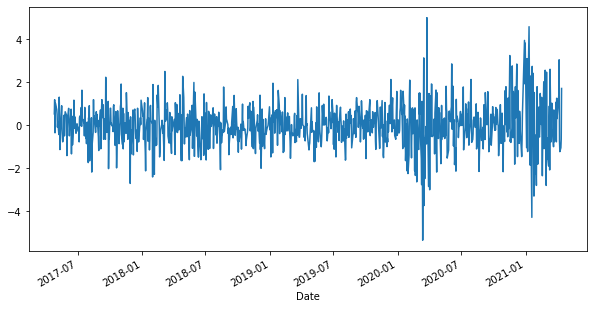

In [ ]:
X_train_d1_norm['Adj Close-1'].plot()

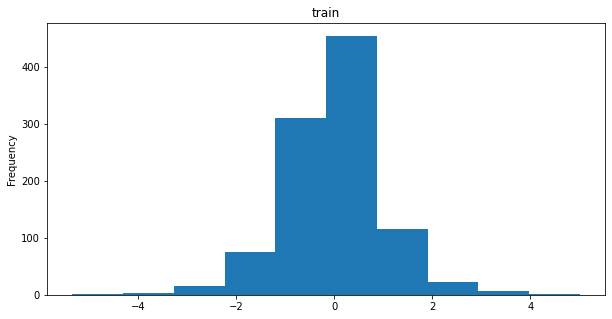

In [ ]:
X_train_d1_norm['Adj Close-1'].plot.hist(title='train')

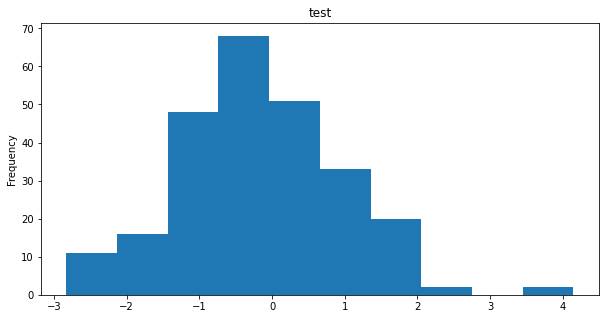

In [ ]:
X_test_d1_norm['Adj Close-1'].plot.hist(title='test')

### Tensors

![](https://miro.medium.com/max/654/1*8jdzMrA33Leu3j3F6A8a3w.png)

#### Batches

In [ ]:
training_data = torch.tensor(pd.concat([X_train_d1_norm, y_train_d1], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_d1_norm, y_test_d1], axis=1).values)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=False)

### ANN

In [ ]:
class OP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(7,1)
    
  def forward(self, X):
    out = torch.relu(self.fc(X))
    return out

In [ ]:
one_neuron = OP()
print(one_neuron(torch.tensor(X_train_d1.iloc[0]).float()))
print(y_train_d1.iloc[0])

tensor([0.], grad_fn=<ReluBackward0>)
27.1572265625


In [ ]:
one_neuron = OP()
epochs = 50
loss_fn = nn.MSELoss()
optimizer = optim.SGD(one_neuron.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch1, loss 481.0567878844246
Epoch2, loss 479.70575362916975
Epoch3, loss 478.24449412027997
Epoch4, loss 477.13922542995874
Epoch5, loss 476.2566898890904
Epoch6, loss 475.54496232290114
Epoch7, loss 474.969111487979
Epoch8, loss 474.5033505152142
Epoch9, loss 474.1263041420588
Epoch10, loss 473.8192308213976
Epoch11, loss 473.56562671964133
Epoch12, loss 473.35308135501924
Epoch13, loss 473.1743895515563
Epoch14, loss 473.02565402076357
Epoch15, loss 472.89960128541975
Epoch16, loss 472.7925800141834
Epoch17, loss 472.7019750201513
Epoch18, loss 472.6235789949932
Epoch19, loss 472.55550977918836
Epoch20, loss 472.49633050343346
Epoch21, loss 472.4452331785172
Epoch22, loss 472.4000984070793
Epoch23, loss 472.3603751772926
Epoch24, loss 472.32577732631137
Epoch25, loss 472.296009729779
Epoch26, loss 472.2694876534598
Epoch27, loss 472.24459693545384
Epoch28, loss 472.2228824676029
Epoch29, loss 472.20210907951235
Epoch30, loss 472.18195669991627
Epoch31, loss 472.16216932024275
Epoc

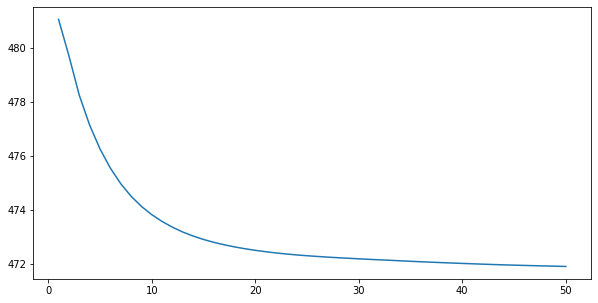

In [ ]:
history = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:7].float()
    y = train_data[:,7].float()
  
    #forward pass
    outputs = one_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  print('Epoch {}, loss {}'.format(epoch, loss_train / len(train_dataloader))) # apresenta o erro médio da época
  history[epoch] = loss_train / len(train_dataloader)

pd.Series(history).plot()



In [ ]:
one_neuron.eval() #desliga o treinamento do modelo
results = []
for test_data in test_dataloader:
    x = test_data[:,:7].float()
    y = test_data[:,7].float()
    
    y_pred = one_neuron(x)
    results.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results[:10]

[0.0, 0.0, 0.0, 0.006098807, 0.0, 0.0, 0.0, 1.4480712, 0.0, 1.3532414]

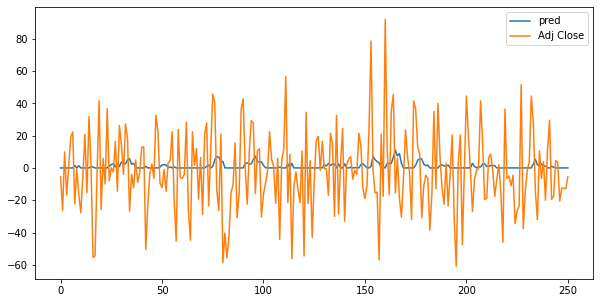

In [ ]:
pd.concat([pd.Series(results, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

In [ ]:
print('Prices - OP Results')
print('r2' ,r2_score(results, y_test_d1))
print('mse' ,mean_squared_error(results, y_test_d1))
print('mae', mean_absolute_error(results, y_test_d1))
resultsprices['OP'] = {'r2':r2_score(results, y_test_d1), \
                 'mse': mean_squared_error(results, y_test_d1), 
                 'mae': mean_absolute_error(results, y_test_d1)}

Prices - OP Results
r2 -187.2816446022491
mse 628.265283711631
mae 19.57882738707075


In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(7,100)
    self.fc3 = nn.Linear(100,1)
    #self.drop1 = nn.Dropout(p=0.5)
    #self.fc2 = nn.Linear(64,32)
    #self.drop2 = nn.Dropout(p=0.5)
  
  def forward(self, X):
    out = torch.tanh(self.fc1(X))
    #out = self.drop1(out)
    #out = torch.relu(self.fc2(out))
    #out = self.drop2(out)
    out = self.fc3(out)
    return out

In [ ]:
multi_neuron = MLP()
print(multi_neuron(torch.tensor(X_train_d1.iloc[0]).float()))
print(y_train_d1.iloc[0])

tensor([-0.6459], grad_fn=<AddBackward0>)
27.1572265625


In [ ]:
multi_neuron = MLP()
epochs = 1000
loss_fn = nn.MSELoss()
#optimizer = optim.RMSprop(multi_neuron.parameters(), lr=0.001)
optimizer = optim.SGD(multi_neuron.parameters(), lr=0.01, weight_decay= 0.005)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch10, loss 472.1953005109514
Epoch20, loss 469.98317173549106
Epoch30, loss 468.27874380444723
Epoch40, loss 467.10897391183033
Epoch50, loss 466.0652768574064
Epoch60, loss 464.9838499038938
Epoch70, loss 464.10504671127075
Epoch80, loss 463.339724465022
Epoch90, loss 462.66132100423175
Epoch100, loss 461.9160196213495
Epoch110, loss 461.268919081915
Epoch120, loss 460.6972982013036
Epoch130, loss 460.1857552906824
Epoch140, loss 459.80941724020335
Epoch150, loss 459.4679807632688
Epoch160, loss 459.08869122701975
Epoch170, loss 458.7442687503875
Epoch180, loss 458.4001179044209
Epoch190, loss 458.0741125439841
Epoch200, loss 457.79850320967415
Epoch210, loss 457.5490692380875
Epoch220, loss 457.2989738101051
Epoch230, loss 457.08313920762805
Epoch240, loss 456.88528018527563
Epoch250, loss 456.6995571075924
Epoch260, loss 456.47628723628935
Epoch270, loss 456.2558312794519
Epoch280, loss 456.08224087669737
Epoch290, loss 455.90626646980405
Epoch300, loss 455.7371903676835
Epoch310

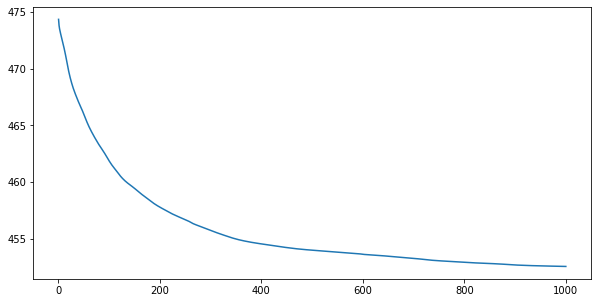

In [ ]:
history = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:7].float()
    y = train_data[:,7].float()
  
    #forward pass
    outputs = multi_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  if (epoch % 10 == 0):
    print('Epoch{}, loss {}'.format(epoch, loss_train / len(train_dataloader))) # apresenta o erro médio da época
  history[epoch] = loss_train / len(train_dataloader)

pd.Series(history).plot()



In [ ]:
multi_neuron.eval()
results = []
for test_data in test_dataloader:
    x = test_data[:,:7].float()
    y = test_data[:,7].float()
    
    y_pred = multi_neuron(x)
    results.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results[:10]

[1.2869357,
 -0.5590868,
 3.8070354,
 3.2451992,
 1.5999026,
 7.0172415,
 -0.019789696,
 -1.6551976,
 -0.81843805,
 1.5772028]

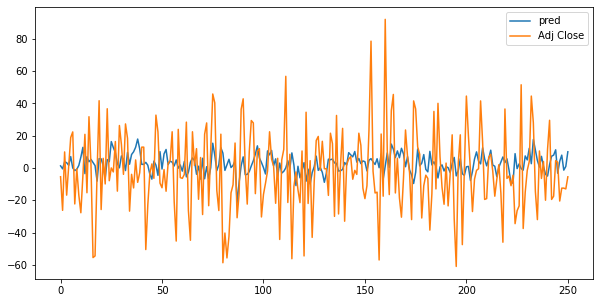

In [ ]:
pd.concat([pd.Series(results, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

In [ ]:
print('Prices - MLP Results')
print('r2' ,r2_score(results, y_test_d1))
print('mse' ,mean_squared_error(results, y_test_d1))
print('mae', mean_absolute_error(results, y_test_d1))
resultsprices['MLP'] = {'r2':r2_score(results, y_test_d1), \
                 'mse': mean_squared_error(results, y_test_d1), 
                 'mae': mean_absolute_error(results, y_test_d1)}

Prices - MLP Results
r2 -18.380914172545666
mse 646.2218204617874
mae 19.993785931294656


In [ ]:
pd.DataFrame(resultsprices)

,KNN,KNN D1 ONE,SVR,SVR multi,OP,MLP
r2,0.709601,0.949576,0.963272,0.362795,-187.281645,-18.380914
mse,4210.650043,854.755165,613.071919,9065.061797,628.265284,646.221820
mae,52.807032,22.534679,19.234204,77.197644,19.578827,19.993786


Redes recorrentes:
* LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
* GRU: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU
